# Lab Part 2 
1. Write a function to calculate included angle from two vectors
2. Identify center of mass (com) position vs. time or 2. Identify gait speed vs. time
3. Identify ankle height vs. time (R, L)
4. Identify knee angle vs. time (R, L)
5. Set up pandas dataframe with outcome variables
6. Code rows in dataframe by participant
7. Plot the data

# What to turn in 
1. A completed notebook with documented code
2. The aggregated csv file

# OpenPose Demo
1. Submit a photo/video of yourself being keypoint detected.
2. Submit the command line call you would use to have openpose perform keypoint detection on a sample .avi file and write the .json results to a directory in of a video itself. 

In [1]:
# imports etc.
import validators
from pathlib import Path
import urllib.request
import numpy as np
import pandas as pd
import json
import seaborn as sns
import math
import os
import glob
from scipy import ndimage
#import requests
import matplotlib.pyplot as plt
sns.set_theme()


In [2]:
# Variables Folders and path
Folders =  glob.glob("json/json/*")
files = glob.glob("json/json/*.json", recursive = True)
data={'Folder Name':[],
        'File Name':[],
        'Frame Number':[],
        'Right knee Angle':[],
        'Left knee Angle':[],
        'Right Ankle Height':[],
        'Left Ankle Height':[],
        'Center of Mass (com)-x':[],
        'Center of Mass (com)-y':[]}

In [3]:
## Base functions for interacting with .json files
# 
# The following routines allow you to load and make a basic plot of a `.json` file from OpenPose.
def extract_kp_from_resource(f,person_id = -1):
    """
    Extract keypoints from resource (file or url) as a numpy vector
    """
    if validators.url(f):
        json_temp = json.load(urllib.request.urlopen(u))['people']
    if Path(f).exists():
        json_temp = json.load(open(f))['people']
        
    try:
        # extract the keypoints of the person specified by person_id; default is last person identified
        keypoints = np.array(extract_kp_from_json(json_temp)["pose_keypoints_2d"][person_id]).astype('float')
    except:
        keypoints = np.empty((75,))
        keypoints[:] = np.NaN
    
    # set missing points (imputed as 0) to nan so that they are not plotted
    keypoints[keypoints==0] = np.nan
    
    return keypoints

def extract_kp_from_json(json_people):
    """
    subfunction for extract_kp_from_resource
    """
    person_id = []
    pose_keypoints_2d = []
    for i in range(0,len(json_people)):
        person_id.append(json_people[i]["person_id"])
        pose_keypoints_2d.append(json_people[i]["pose_keypoints_2d"])
    # return a dict
    return {'person_id': person_id, 'pose_keypoints_2d': pose_keypoints_2d}

def convert_kp_to_df(keypoints):
    """
    reshape keypoint vector to dataframe
    """
    # reshape to 25 X 3; the coordinates are x, y, confidence in estimate
    kin = keypoints.reshape((-1,3))
        
    # create a dataframe
    df = pd.DataFrame({'keypoint': ["Nose", "Neck", "RShoulder", "RElbow", "RWrist", "LShoulder", "LElbow", "LWrist", "MidHip", "RHip", "RKnee", "RAnkle", "LHip", "LKnee", "LAnkle", "REye", "LEye", "REar", "LEar", "LBigToe", "LSmallToe", "LHeel", "RBigToe", "RSmallToe", "RHeel"], 'x': kin[:,0], 'y': kin[:,1], 'confidence': kin[:,2]})

    return df.set_index('keypoint')

def plot_body25_df(df):
    """
    plot a dataframe corresponding to body25 coordinates
    """
    segments = [['Neck', 'REar', 'LEar', 'Neck'],
        ['Nose', 'REye', 'LEye', 'Nose'],
        ['RShoulder', 'Neck', 'LShoulder','RShoulder'],
        ["LShoulder", "LElbow", "LWrist"],
        ["RShoulder", "RElbow", "RWrist"],
        ['RShoulder', 'RHip', 'LHip','LShoulder','RShoulder'],
        ['LHip', 'MidHip', 'RHip'],
        ["LHip", "LKnee", "LAnkle"],
        ["RHip", "RKnee", "RAnkle"],
        ['LAnkle', 'LHeel', 'LBigToe', 'LSmallToe', 'LAnkle'],
        ['RAnkle', 'RHeel', 'RBigToe', 'RSmallToe', 'RAnkle']]
    
    fig, ax = plt.subplots()
    ax.set(xlim=[0, 1920], ylim=[1080, 0], xlabel='X', ylabel='Y')
    [sns.lineplot(data=df.loc[s].reset_index(), x = "x", y = "y", ax = ax) for s in segments]

In [4]:
# function to calculate the outcomes of the dataset: 
def angle_between(v1, v2):
    """ 
    Returns the angle in degrees between two vectors v1 and v2:
    """
    v1= np.asarray(v1)
    v2= np.asarray(v2)
    v1_u = v1 / np.linalg.norm(v1)
    v2_u = v2 / np.linalg.norm(v2)
    return math.degrees(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))

def df_to_outcomes(folder, Frames, data, files):
    """
    #Return a dataframe with kinematic outcomes derived from a single body 25 dataframe
    """
    folder = folder.replace("\\","/")

    for i in range(len(Frames)):
        #print(folder)
        #'Right Ankle Hight
        Frame = Frames[i]
        FileName =os.path.basename(Frame)
        FrameName =os.path.basename(Frame).split("_")[1]
        data['Folder Name'].append(folder) 
        data['File Name'].append(FileName) 
        data['Frame Number'].append(FrameName.lstrip('0'))
        #data['Frame Number'].append(FrameName.lstrip('0')+"/"+str(len(Frames)))
        calc_outcomes(folder, FileName)        
    return data
    

def calc_outcomes(folder, fileName):
    """
    Calculate outcomes from a file or  other resource 
    return as a dataframe in a standerd formate
    """
    dirctory = folder+"/"+fileName
    kp_u = extract_kp_from_resource(dirctory)
    #print(dirctory)
    kp_f = extract_kp_from_resource(fileName)
    df_u = convert_kp_to_df(kp_u)
    df_f = convert_kp_to_df(kp_f)
    F=df_u
# Right Knee Angle: 
    RHipx=F.iloc[9]['x'] #RHip[9], RKnee[10],RAnkle[11]
    RHipy=F.iloc[9]['y']
    RKneex=F.iloc[10]['x'] 
    RKneey=F.iloc[10]['y']
    RAnklex=F.iloc[11]['x'] 
    RAnkley=F.iloc[11]['y']

    v1R = (RHipx-RKneex, RHipy -RKneey)
    v2R = (RKneex-RAnklex, RKneey-RAnkley)
    RkneeAngle=angle_between(v1R, v2R)
    
# Left Knee Angle:
    LHipx=F.iloc[12]['x'] #LHip[12], LKnee[13],LAnkle[14]
    LHipy=F.iloc[12]['y']
    LKneex=F.iloc[13]['x'] 
    LKneey=F.iloc[13]['y']
    LAnklex=F.iloc[14]['x'] 
    LAnkley=F.iloc[14]['y']

    v1L = (LHipx-LKneex, LHipy -LKneey)
    v2L = (LKneex-LAnklex, LKneey-LAnkley)
    LkneeAngle=angle_between(v1L, v2L)
# Calculate Ankle Hight
    RAnkleHight=RAnkley-F.min()['y']
    LAnkleHight=LAnkley-F.min()['y']

# Calculate center of mass (COM): 
# Calculate center of mass (COM): 
    F=F.dropna() 
    xy=F[['x','y']]
    com = tuple(np.mean(xy))
    x=com[0]
    y=com[1]

    data['Right knee Angle'].append(RkneeAngle) 
    data['Left knee Angle'].append(LkneeAngle) 
    data['Right Ankle Height'].append(RAnkleHight) 
    data['Left Ankle Height'].append(LAnkleHight) 
    data['Center of Mass (com)-x'].append(x)
    data['Center of Mass (com)-y'].append(y)

In [5]:
for folder in Folders:
    Frams = glob.glob(folder+"/*.json")
    df_to_outcomes(folder, Frams,data,files)
outcomes = pd.DataFrame(data)
outcomes

,Folder Name,File Name,Frame Number,Right knee Angle,Left knee Angle,Right Ankle Height,Left Ankle Height,Center of Mass (com)-x,Center of Mass (com)-y
0,"json/json/1, 10-25, Normal gait, Sag, Paige",f_000000000000_keypoints.json,,NaN,NaN,NaN,NaN,7.808040,326.394143
1,"json/json/1, 10-25, Normal gait, Sag, Paige",f_000000000001_keypoints.json,1,NaN,NaN,NaN,NaN,10.558215,348.921500
2,"json/json/1, 10-25, Normal gait, Sag, Paige",f_000000000002_keypoints.json,2,NaN,0.026289,NaN,500.247,11.183177,513.824235
3,"json/json/1, 10-25, Normal gait, Sag, Paige",f_000000000003_keypoints.json,3,NaN,0.024306,NaN,503.207,9.588303,465.725500
4,"json/json/1, 10-25, Normal gait, Sag, Paige",f_000000000004_keypoints.json,4,NaN,0.065731,NaN,370.929,9.478119,458.302467
...,...,...,...,...,...,...,...,...,...
3370,"json/json/9, 10-25 Circum hip L gait, Sag, Paige",f_000000000169_keypoints.json,169,NaN,NaN,NaN,NaN,NaN,NaN
3371,"json/json/9, 10-25 Circum hip L gait, Sag, Paige",f_000000000170_keypoints.json,170,NaN,NaN,NaN,NaN,NaN,NaN
3372,"json/json/9, 10-25 Circum hip L gait, Sag, Paige",f_000000000171_keypoints.json,171,NaN,NaN,NaN,NaN,NaN,NaN
3373,"json/json/9, 10-25 Circum hip L gait, Sag, Paige",f_000000000172_keypoints.json,172,NaN,NaN,NaN,NaN,NaN,NaN


Right knee Angle: 1.0192452811899542 ,Left knee Angle: 15.634537391150769
Right Ankle Hight: 494.458 ,Left Ankle Hight: 485.636
987.134695652174 574.2872608695652


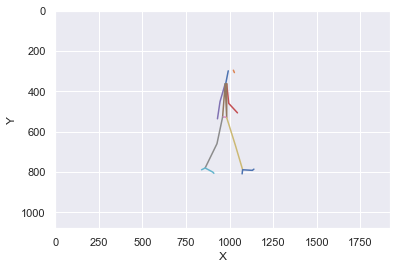

In [18]:
#Sample load and plot

#
u = "json/json/1, 10-25, Normal gait, Sag, Paige/f_000000000100_keypoints.json"
f = 'f_000000000100_keypoints.json'

kp_u = extract_kp_from_resource(u)
kp_f = extract_kp_from_resource(f)

df_u = convert_kp_to_df(kp_u)
df_f = convert_kp_to_df(kp_f)

plot_body25_df(df_u)

#angle_between(F.loc[:,"x"].values, F.loc[:,"y"].values)
F=df_u
# Right Knee Angle: 
RHipx=F.iloc[9]['x'] #RHip[9], RKnee[10],RAnkle[11]
RHipy=F.iloc[9]['y']
RKneex=F.iloc[10]['x'] 
RKneey=F.iloc[10]['y']
RAnklex=F.iloc[11]['x'] 
RAnkley=F.iloc[11]['y']

v1R = (RHipx-RKneex, RHipy -RKneey)
v2R = (RKneex-RAnklex, RKneey-RAnkley)
RkneeAngle=angle_between(v1R, v2R)

# Left Knee Angle:
LHipx=F.iloc[12]['x'] #LHip[12], LKnee[13],LAnkle[14]
LHipy=F.iloc[12]['y']
LKneex=F.iloc[13]['x'] 
LKneey=F.iloc[13]['y']
LAnklex=F.iloc[14]['x'] 
LAnkley=F.iloc[14]['y']

v1L = (LHipx-LKneex, LHipy -LKneey)
v2L = (LKneex-LAnklex, LKneey-LAnkley)
LkneeAngle=angle_between(v1L, v2L)
print("Right knee Angle:",RkneeAngle, ",Left knee Angle:",LkneeAngle)

# Ankle Hight: 
RAnkleHight=RAnkley-F.min()['y']
LAnkleHight=LAnkley-F.min()['y']
print("Right Ankle Hight:",RAnkleHight, ",Left Ankle Hight:",LAnkleHight)

# Calculate center of mass (COM): 
F=F.dropna() 
xy=F[['x','y']]
com = tuple(np.mean(xy))
print(com[0],com[1])

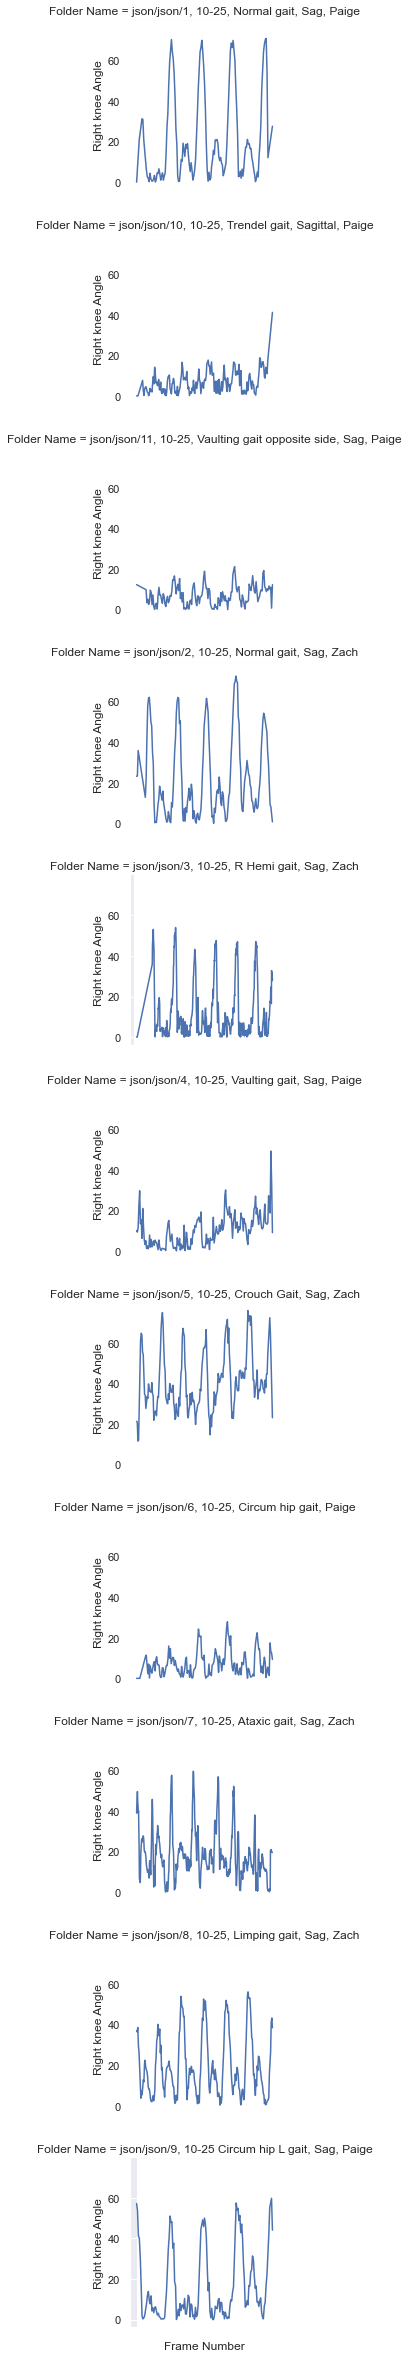

In [13]:
# Plot Right Knee Angle Vs. Time 
g = sns.FacetGrid(outcomes, row="Folder Name",sharex=False)
g.map(sns.lineplot, "Frame Number", "Right knee Angle")
g.set(xticklabels=[])
plt.savefig('RightkneeAngle.png',dpi=300, bbox_inches='tight')

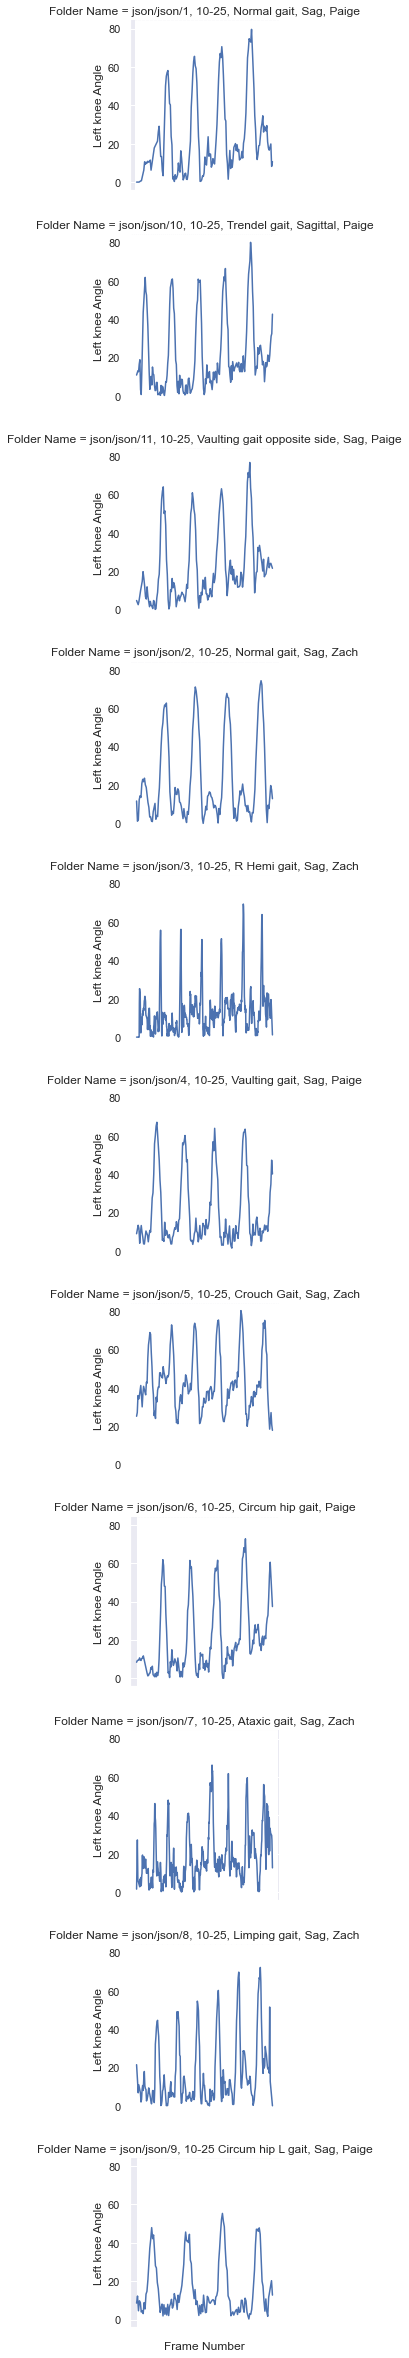

In [14]:
# Plot Left Knee Angle Vs. Time 
g = sns.FacetGrid(outcomes, row="Folder Name",sharex=False)
g.map(sns.lineplot, "Frame Number", "Left knee Angle")
g.set(xticklabels=[])
plt.savefig('LeftkneeAngle.png',dpi=300, bbox_inches='tight')

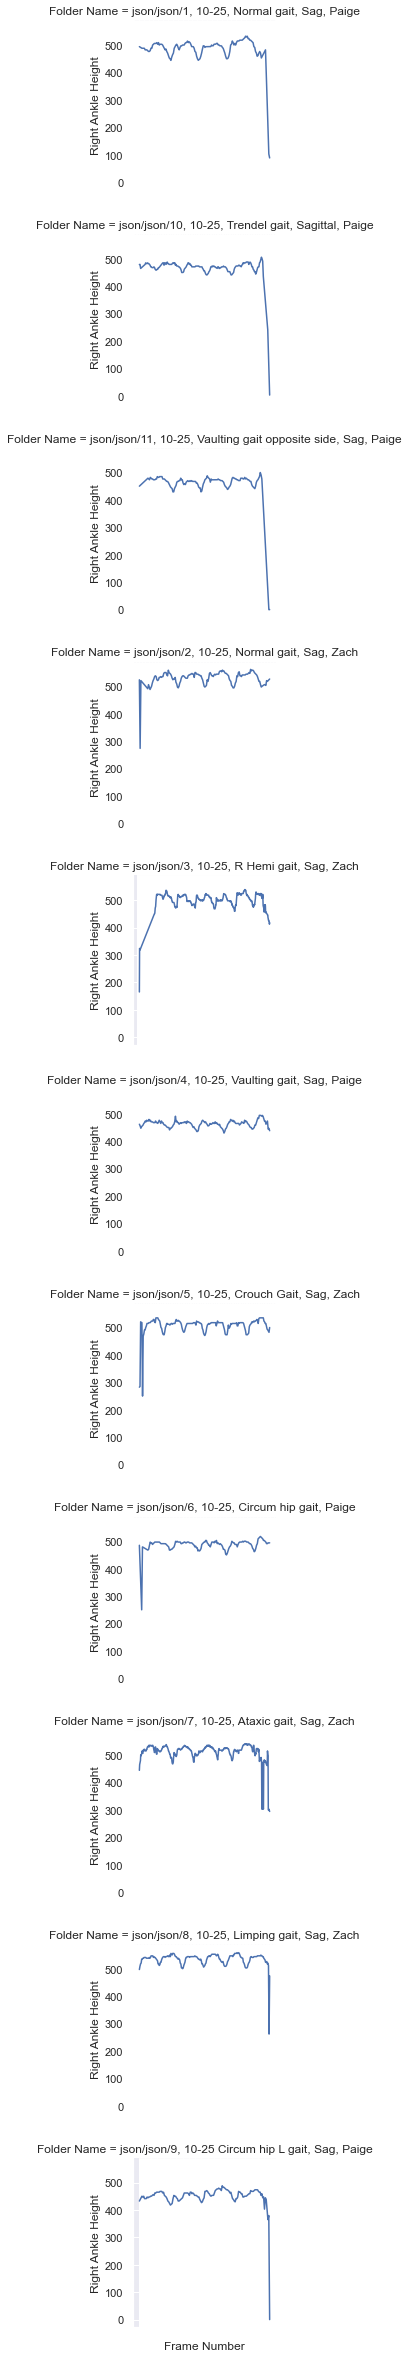

In [15]:
# Plot Right Ankle Hieght Vs. Time 
g = sns.FacetGrid(outcomes, row="Folder Name",sharex=False)
g.map(sns.lineplot, "Frame Number", "Right Ankle Height")
g.set(xticklabels=[])
plt.savefig('RightAnkleHieght.png',dpi=300, bbox_inches='tight')

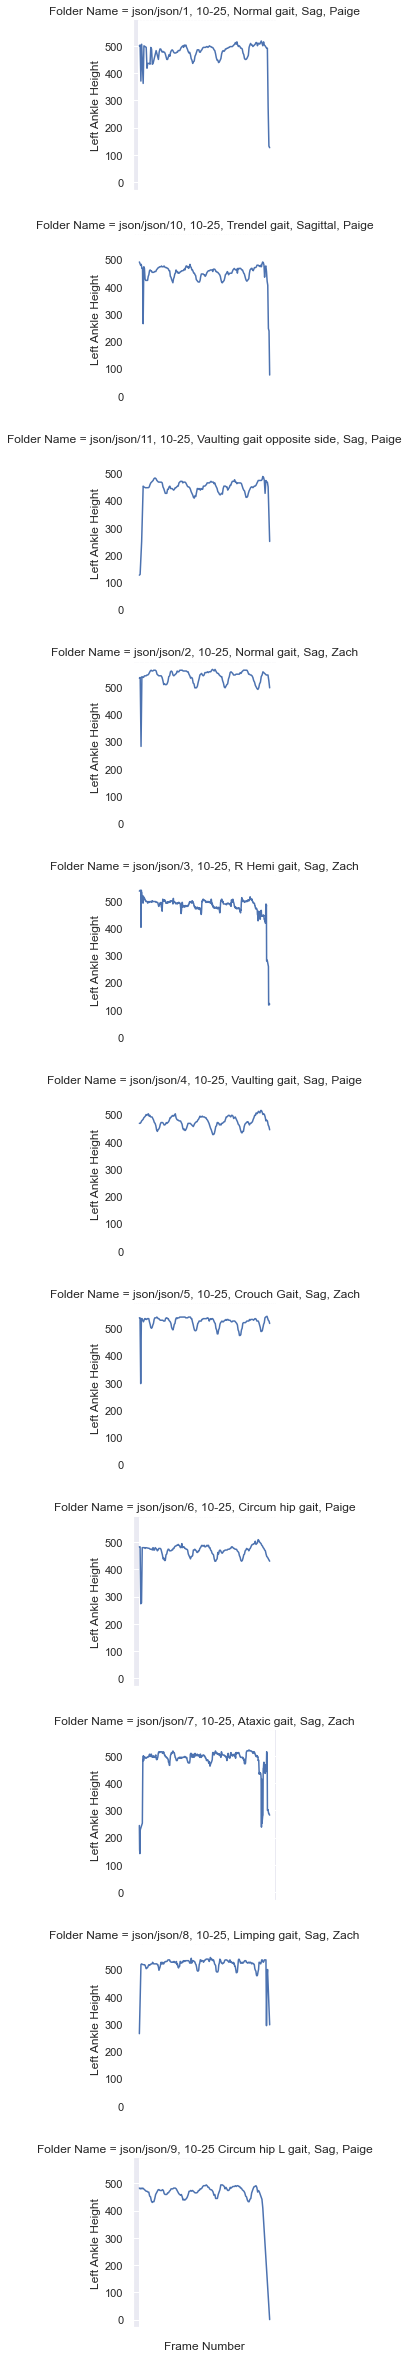

In [16]:
# Plot Left Ankle Hieght Vs. Time 
g = sns.FacetGrid(outcomes, row="Folder Name",sharex=False)
g.map(sns.lineplot, "Frame Number", "Left Ankle Height")
g.set(xticklabels=[])
plt.savefig('LeftAnkleHieght.png',dpi=300, bbox_inches='tight')

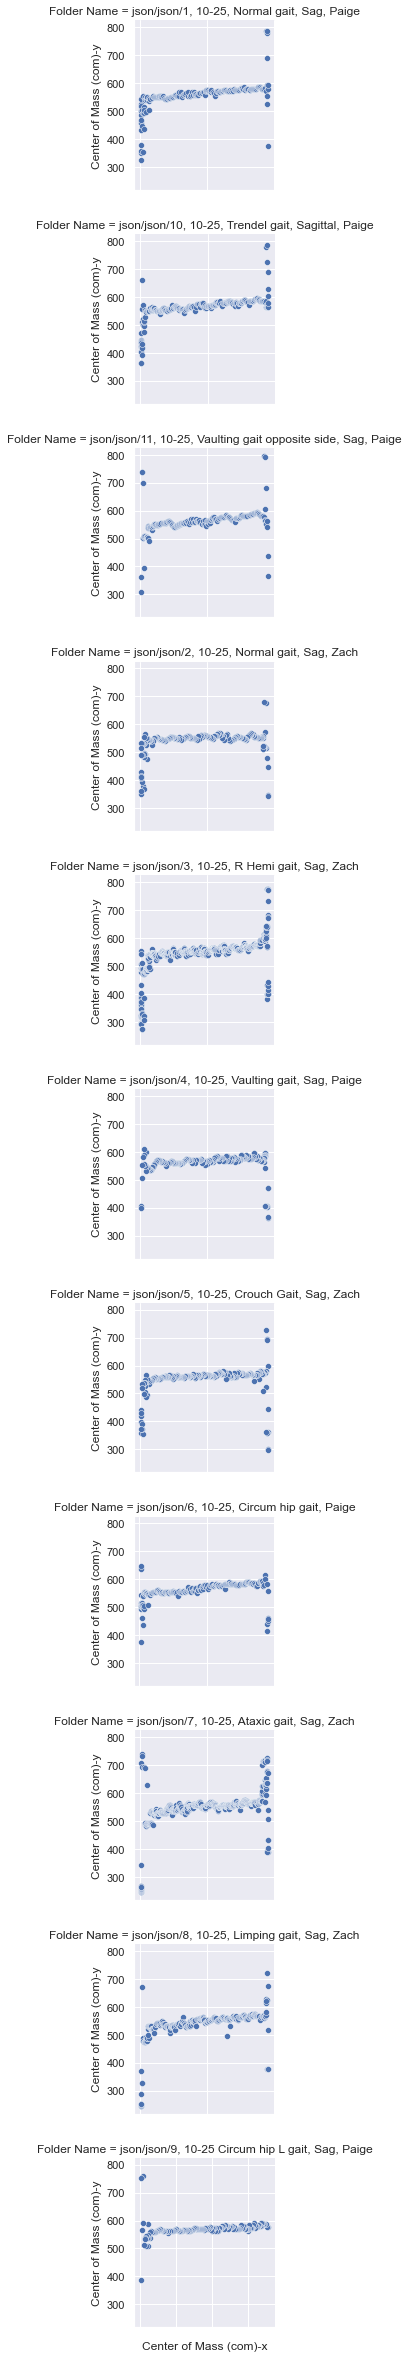

In [17]:
#plot The Center of Mass over time in every folder:
g = sns.FacetGrid(outcomes, row="Folder Name",sharex=False)
g.map(sns.scatterplot, "Center of Mass (com)-x", "Center of Mass (com)-y")
g.set(xticklabels=[])
plt.savefig('comvstime.png',dpi=300, bbox_inches='tight')

In [12]:
# Write the data to a `csv` file
outcomes.to_csv("outcomes.csv",index=False)

# Running OpenPose on Windows using powershell:
A video of running the command line using the demo, a zip file for the results of a personal video (json files, video with keypoint) were submitted.

In [ ]:
# Command Line of openpose to preform keypoint detection on a personal video and saving the video with keypoint(live iphone image)
bin\OpenPoseDemo.exe --video examples/media/InNYRita.avi --write_video NYRitewkeypoint.avi
# Command Line of openpose to save the .json files: 
bin\OpenPoseDemo.exe --video examples/media/InNYRita.avi --num_gpu 0 --write_video InNYRita_output/result.avi --write_json InNYRita_output/